## Boston AirBnB open data with the CRISP-DM (Cross Industry Process for Data Mining)

To get general AirBnB business insight, the Boston data from AirBnB will be analyzed based on the CRISP-DM. The subprocesses of the CRISP-DM are written below.

`1`. Business Understanding

`2`. Data Understanding

`3`. Prepare Data

`4`. Data Modeling

`5`. Evaluate the Results

`6`. Deploy

In [213]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar #To check holidays in the U.S
import time
import copy
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [214]:
# Load the AirBnB files
df_listing = pd.read_csv('./listings.csv')
df_calendar = pd.read_csv('./calendar.csv')
df_reviews = pd.read_csv('./reviews.csv')

## 1. Business Understanding

Business Questions 
    - What are the most relevant features of the groups over the 90 percentile and under the 10 percentile?
    - What are the most relevant features to be cared for the two traveler group and more than four traveler group?
    - How is the price of AirBnb adjusted in terms of seasons and locations?

## 2. Data Understanding

Check and play around the dataframes loaded before to get some idea or to get the business quesations progressed.
### 2.1. For df_listing

In [215]:
# Setting option for seeing the whole columns of dataframes
pd.set_option('display.max_columns', None)  

In [415]:
print(df_listing.shape)
df_listing.head(n=5)


(3585, 100)


99999999

In [217]:
df_listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url                       2986

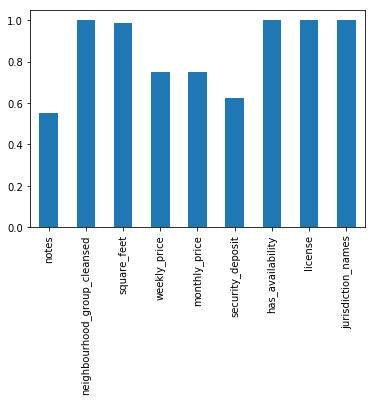

In [218]:
# Checking the columns consisting of missing values over 50%
df_missing = df_listing.isna().mean()
df_missing[df_missing>0.5].plot.bar()

In [219]:
print("# of id:",df_listing.id.unique().size)
print("# of host_id:",df_listing.host_id.unique().size)
# There are some hosts who take care of more than two ids

# of id: 3585
# of host_id: 2181


# of accommodates: [ 4  2  3  5  1  8  6 16  7  9 10 12 11 14]
2     0.413668
4     0.181311
1     0.122455
3     0.119386
5     0.068340
6     0.056625
8     0.015342
7     0.010879
10    0.005300
9     0.002789
12    0.001395
11    0.001116
14    0.000837
16    0.000558
Name: accommodates, dtype: float64
Accomodates equal or less than 2 is 53.61 %
Accomodates more than 2 is 42.57 %


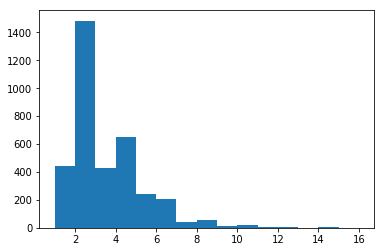

In [220]:
print("# of accommodates:",df_listing.accommodates.unique())
tmp = df_listing.accommodates.value_counts(ascending=False)/df_listing.accommodates.size
print(tmp)
print("Accomodates equal or less than 2 is {:5.2f} %".format((tmp[1]+tmp[2])*100))
print("Accomodates more than 2 is {:5.2f} %".format((tmp[3]+tmp[4]+tmp[5]+tmp[6])*100))
# 96% of total id can be categorized into the group with less than 2 people or the group with more than 2 people
plt.hist(df_listing.accommodates, bins=15)
plt.show()

In [221]:
print("# of bed_type:",df_listing.bed_type.unique())

# of bed_type: ['Real Bed' 'Pull-out Sofa' 'Futon' 'Airbed' 'Couch']


### 2.2. For df_calendar

(1308890, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
listing_id    1308890 non-null int64
date          1308890 non-null object
available     1308890 non-null object
price         643037 non-null object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB
None


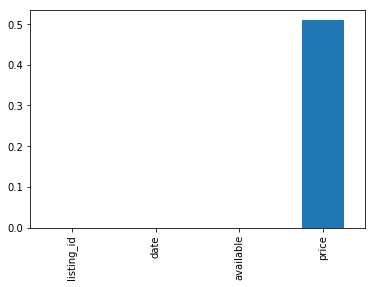

In [222]:
print(df_calendar.shape)
print(df_calendar.info())
df_calendar.head()
df_missing_calendar = df_calendar.isna().mean()
df_missing_calendar.plot.bar()

In [223]:
# Modify df_calendar for future work
# Special event : marathon, new academic season

def modify_calendar(df_calendar):
    '''
    This function creates 'year', 'month', 'day', 'weekday',  and 'week_number' columns from 'date' coulmn of df_calendar 
    and remove '$' string from 'price' coulmn.
    
    Input : a Pandas dataframe having a date data column
    Output : a Pandas dataframe having year, month, day, weekday, us_holiday columns
    '''
    # Split date column into year, month,day, weekday columns
    # The day of the week with Monday=0, Sunday=6
    # Set the range of weekends from Friday to Sunday
    df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
    df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month
    df_calendar['day'] = pd.DatetimeIndex(df_calendar['date']).day
    df_calendar['weekday'] = pd.DatetimeIndex(df_calendar['date']).weekday
    df_calendar['week_number'] = pd.DatetimeIndex(df_calendar['date']).week
    df_calendar['price']= df_calendar['price'].str.replace('$','')
    df_calendar['price']=df_calendar['price'].str.replace(',','')
    df_calendar['price'] = df_calendar['price'].astype(float)
    
    # Add us_holiday column
    cal = calendar()
    holidays = cal.holidays(start=df_calendar.date.min(), end=df_calendar.date.max())
    df_calendar['us_holiday'] = df_calendar.date.astype('datetime64').isin(holidays)
    
    # Add weekend column #Friday, Saturday
    weekend = [4,5]
    df_calendar['weekend'] = df_calendar.weekday.isin(weekend)
    
    # Replace values in weekday column 
    df_calendar['weekday'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)
    
    return df_calendar

In [224]:
df_cal_modified = modify_calendar(df_calendar)
print(df_cal_modified.shape[0]/365)

# Each listing_id has 365 rows

3586.0


In [225]:
def add_availabledays_price(df_listing, df_cal_modified):
    '''
    This function creates columns of 'unavail_days', 'avail_days_weekends', 
    'avail_days_weekdays', 'price_weekend', and 'price_weekday' where calculated from df_cal_modified on df_listing.
    
    Input : 
    - A Pandas dataframe made from 'listings.csv' : df_listing
    - A pandas dataframe modified by modify_calendar() : df_cal_modified
    
    Output :
    - the modified df_listing dataframe with new 'unavail_days', 'avail_days_weekends',
    'avail_days_weekdays', 'price_weekend', and 'price_weekday' columns 
    '''
    id_list = df_listing.id[:]
    unavailable_days_array = np.array([])
    avail_days_weekends_array =  np.array([])
    avail_days_weekdays_array = np.array([])
    price_weekend_array = np.array([])
    price_weekday_array = np.array([])

    for i in np.nditer(id_list):
        tmp = df_cal_modified[(df_cal_modified.listing_id == i)] # Make a dataframe coming from df_listing with a certain id
        available_dict = tmp.available.value_counts().to_dict()
        if 'f' in available_dict:
            unavailable_days = tmp[tmp.available == 'f'].shape[0]
        else:
            unavailable_days = 0

        if 't' in available_dict:
            available_weekends = tmp[(tmp.available == 't') & (tmp.weekend == True)].shape[0]
            available_weekdays = tmp[(tmp.available == 't') & (tmp.weekend == False)].shape[0]
            price_weekend = tmp[(tmp.weekend == True) & (tmp.available == 't')].price.astype(float).describe()['mean']
            price_weekday = tmp[(tmp.weekend == False) & (tmp.available == 't')].price.astype(float).describe()['mean']

        else:
            available_weekends = 0
            available_weekdays = 0
            price_weekend = np.nan
            price_weekday = np.nan


        unavailable_days_array = np.append(unavailable_days_array, unavailable_days)
        avail_days_weekends_array = np.append(avail_days_weekends_array, available_weekends)
        avail_days_weekdays_array = np.append(avail_days_weekdays_array, available_weekdays)
        price_weekend_array = np.append(price_weekend_array, price_weekend)
        price_weekday_array = np.append(price_weekday_array, price_weekday)

    df_listing['unavail_days'] = pd.Series(unavailable_days_array)
    df_listing['avail_days_weekends'] = pd.Series(avail_days_weekends_array)
    df_listing['avail_days_weekdays'] = pd.Series(avail_days_weekdays_array)
    df_listing['price_weekend'] = pd.Series(price_weekend_array)
    df_listing['price_weekday'] = pd.Series(price_weekday_array)


In [226]:
start = time.time() 
add_availabledays_price(df_listing, df_cal_modified)
print("time :", time.time() - start)
df_listing.tail(n=10)

time : 61.9275279045105


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday
3575,5280827,https://www.airbnb.com/rooms/5280827,20160906204935,2016-09-07,Private cozy room,"Cozy room near T station. 5 min walking to T, ...",NaN,"Cozy room near T station. 5 min walking to T, ...",none,NaN,NaN,NaN,NaN,NaN,1. No damage to the house or furniture 2. No S...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,https://a2.muscache.com/im/pictures/116bc87c-8...,19246369,https://www.airbnb.com/users/show/19246369,Joe,2014-07-31,"Somerville, Massachusetts, United States",NaN,within an hour,96%,100%,f,https://a2.muscache.com/im/users/19246369/prof...,https://a2.muscache.com/im/users/19246369/prof...,Somerville,28,28,"['email', 'phone', 'reviews', 'jumio']",t,t,"Washington Street, Somerville, MA 02143, Unite...",Somerville,Charlestown,NaN,Somerville,MA,02143,Boston,"Somerville, MA",US,United States,42.382681,-71.085720,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,$69.00,NaN,NaN,$95.00,NaN,1,$24.00,2,1125,a week ago,NaN,25,51,81,356,2016-09-06,6,2015-03-07,2016-08-20,70.0,8.0,7.0,9.0,10.0,8.0,7.0,f,NaN,NaN,t,strict,f,f,8,0.33,9.0,101.0,255.0,75.000000,69.000000
3576,14689681,https://www.airbnb.com/rooms/14689681,20160906204935,2016-09-07,Beautiful loft style bedroom with large bathroom,You'd be living on the top floor of a four sto...,NaN,You'd be living on the top floor of a four sto...,none,NaN,NaN,NaN,NaN,NaN,NaN,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,https://a2.muscache.com/im/pictures/725a70f0-a...,50546418,https://www.airbnb.com/users/show/50546418,Thomas,2015-12-04,"Somerville, Massachusetts, United States",NaN,within a day,100%,100%,f,https://a2.muscache.com/im/pictures/f44ebd43-8...,https://a2.muscache.com/im/pictures/f44ebd43-8...,Cambridge,1,1,"['email', 'phone', 'reviews', 'jumio']",t,t,"Putnam Avenue, Cambridge, MA 02139, United States",Cambridge,Allston,NaN,Cambridge,MA,02139,Boston,"Cambridge, MA",US,United States,42.365112,-71.114801,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Air Conditioning"",Kitchen,""Indoor Fireplace""...",NaN,$124.00,NaN,NaN,$200.00,$85.00,1,$0.00,2,1125,2 weeks ago,NaN,5,5,20,110,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN,255.0,32.0,78.0,152.875000,131.820513
3577,13750763,https://www.airbnb.com/rooms

In [227]:
print(df_listing.shape)
df_listing.info()

(3585, 100)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 100 columns):
id                                  3585 non-null int64
listing_url                         3585 non-null object
scrape_id                           3585 non-null int64
last_scraped                        3585 non-null object
name                                3585 non-null object
summary                             3442 non-null object
space                               2528 non-null object
description                         3585 non-null object
experiences_offered                 3585 non-null object
neighborhood_overview               2170 non-null object
notes                               1610 non-null object
transit                             2295 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 non-null object
thumbnail_url              

## 3. Prepare data

## Strategies
    - Remove irrelevant columns
    - Change object type columns to numeric columns or manipulate them using one hot encoding
    - Nan 채우기
    - integrated_score 만들기


In [228]:
def clean_listing_df(df_listing):
    '''
    This function removes irrelevant columns in the df_listing dataframe.

    Input : 
    - A Pandas dataframe made from 'listings.csv' : df_listing

    Output :
    - Cleaned df_listing
    '''
    # Drop columns having 50% of nan value
    df_missing = df_listing.isna().mean()
    df_listing_modi1 = df_listing.drop(df_missing[df_missing>0.5].index.to_list(), axis=1)
    # Drop columns related with urls and other irrelevant columns
    remove_list1 = ['listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 
                'host_thumbnail_url', 'host_picture_url', 'country_code', 'country']
    df_listing_modi1.drop(remove_list1, axis=1, inplace=True)
    # Drop the columns because of data overlap [city, smart_location], Only one value [state], 
    # Wrong data [market, calendar_last_scraped]
    remove_list2 = ['smart_location', 'state', 'name', 'summary', 'space', 'description','neighborhood_overview',
                'transit','access','market','calendar_last_scraped']
    df_listing_modi1.drop(remove_list2, axis=1, inplace=True)
    
    # Modify 'house_rules' columns to 'house_rules_exist_tf' having True value if there is a rule.
    # False value, if there is no rule.
    df_listing_modi1['house_rules_exist_tf']= pd.notna(df_listing_modi1.house_rules)
    df_listing_modi1.drop(['house_rules'], axis=1, inplace=True)
    # Remove columns having 1000 unique string valuses and irrelevant data
    remove_list3 = ['interaction', 'host_name', 'host_since', 'host_about', 'street','first_review','experiences_offered','requires_license',
                    'last_review','host_location','neighbourhood_cleansed','experiences_offered','requires_license']
    df_listing_modi2 = df_listing_modi1.drop(remove_list3, axis=1)

    # Change the columns 'host_response_rate', 'host_acceptance_rate' to float type
    columns_change_type = ['host_response_rate','host_acceptance_rate', 'price', 'cleaning_fee']
    for i in columns_change_type:
        df_listing_modi2[i] = df_listing_modi2[i].str.replace('%','')
        df_listing_modi2[i] = df_listing_modi2[i].str.replace('$','')
        df_listing_modi2[i] = df_listing_modi2[i].str.replace(',','')
        df_listing_modi2[i] = df_listing_modi2[i].astype(float)
    
    # Modify and Split values in 'amenities' column
    df_listing_modi2.amenities = df_listing_modi2.amenities.str.replace("[{}]", "")
    df_amenities = df_listing_modi2.amenities.str.get_dummies(sep = ",")
    df_amenities = df_amenities.add_prefix('amenities_')
    df_listing_modi2 = pd.concat([df_listing_modi2, df_amenities], axis=1)
    df_listing_modi2 = df_listing_modi2.drop('amenities', axis=1)
    
    # Use get_dummies for columns having unique values less then 10
    columns_of_object_less10 =[]
    for i,j in zip(df_listing_modi2.columns.to_list(), df_listing_modi2.dtypes.to_list()):
        if j == object and len(df_listing_modi2[i].value_counts()) < 10 :
            columns_of_object_less10.append(i)
    df_listing_modi2 = pd.get_dummies(df_listing_modi2, columns=columns_of_object_less10, prefix=columns_of_object_less10, 
                                      dummy_na=True)
    
    #  Modify 'extra_people' coulmn to get boolean type of 'extra_people_fee_tf'
    df_listing_modi2['extra_people'] = df_listing_modi2['extra_people'].astype(str)
    df_listing_modi2['extra_people']= df_listing_modi2['extra_people'].str.replace('$','')
    df_listing_modi2['extra_people']=df_listing_modi2['extra_people'].str.replace(',','')
    df_listing_modi2['extra_people'] = df_listing_modi2['extra_people'].astype(float)
    df_listing_modi2['extra_people'] = df_listing_modi2['extra_people'].replace(to_replace=0, value=np.nan)
    df_listing_modi2['extra_people_fee_tf']= pd.notna(df_listing_modi2.extra_people)
    df_listing_modi2 = df_listing_modi2.drop('extra_people', axis=1)
    
    # Modify and Split values in 'host_verifications' column
    df_listing_modi2.host_verifications = df_listing_modi2.host_verifications.str.replace("[", "")
    df_listing_modi2.host_verifications = df_listing_modi2.host_verifications.str.replace("]", "")
    df_host_verifications = df_listing_modi2.host_verifications.str.get_dummies(sep = ",")
    df_host_verifications = df_host_verifications.add_prefix('host_verification_')
    df_listing_modi2 = pd.concat([df_listing_modi2, df_host_verifications], axis=1)
    df_listing_modi2 =  df_listing_modi2.drop(['host_verifications'], axis=1)
    df_listing_modi2 =  df_listing_modi2.drop(['host_neighbourhood'], axis=1)
    
    # Modify 'calendar_updated' column
    df_listing_modi2["calendar_updated_1weekago"] = np.where(df_listing_modi2['calendar_updated'].str.contains(
        "days|yesterday|today|a week ago")==True, 'yes', 'more_than_1week')
    df_listing_modi2 =  df_listing_modi2.drop(['calendar_updated'], axis=1)
    
    # Use get_dummies for the columns 'neighbourhood', 'city', 'zipcode', 'property_type'
    tmp = df_listing_modi2.columns.to_list()
    tmp1 = df_listing_modi2.dtypes.to_list()
    columns_of_object_over10 =[]
    for i,j in zip(tmp,tmp1):
            if j == object and len(df_listing_modi2[i].value_counts()) > 10 :
                columns_of_object_over10.append(i)
                
    df_listing_modi2 = pd.get_dummies(df_listing_modi2, columns=columns_of_object_over10, 
                                      prefix=columns_of_object_over10, dummy_na=True)
    
    df_listing_modi2 = pd.get_dummies(df_listing_modi2, columns=['calendar_updated_1weekago','house_rules_exist_tf','extra_people_fee_tf'], 
                                  prefix=['calendar_updated_1weekago','house_rules_exist_tf','extra_people_fee_tf'], dummy_na=True)
    
    df_listing_modi2["host_response_rate_100"] = np.where(df_listing_modi2['host_response_rate'] ==100, True, False)
    df_listing_modi2["host_acceptance_rate_100"] = np.where(df_listing_modi2['host_acceptance_rate'] ==100, True, False)
    df_listing_modi2 =  df_listing_modi2.drop(['host_response_rate','host_acceptance_rate','reviews_per_month'], axis=1)
    
    #bathrooms, bedrooms, beds, cleaning_fee, review_scores_rating, review_... : : fillna with mean value
    columns1 = ['bathrooms','bedrooms','beds','cleaning_fee','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
            'review_scores_communication','review_scores_location','review_scores_value']
    df_listing_modi2[columns1] = df_listing_modi2[columns1].fillna(df_listing_modi2.mean())
    df_listing_modi2.price_weekend.fillna(df_listing_modi2.price, inplace=True)
    df_listing_modi2.price_weekday.fillna(df_listing_modi2.price, inplace=True)
    df_listing_modi2['integrated_score_log'] = np.log(df_listing_modi2['review_scores_rating']*df_listing_modi2['number_of_reviews']+1)
    
    df_listing_modi2 = pd.get_dummies(df_listing_modi2, columns=['host_response_rate_100','host_acceptance_rate_100'], 
                                  prefix=['host_response_rate_100','host_acceptance_rate_100'])
    df_listing_modi2 = df_listing_modi2.drop(['id', 'host_id', 'latitude', 'longitude','price','host_listings_count','host_total_listings_count'], axis=1)
    
    
    
    return df_listing_modi2


    
        

In [419]:
# columns_change_type = ['host_response_rate','host_acceptance_rate', 'price', 'cleaning_fee']
# for i in columns_change_type:
#     print(df_listing[i].head())
df_listing_modi2 = clean_listing_df(df_listing)  
print(df_listing_modi2.shape)
tmp = df_listing_modi2.columns.to_list()
tmp

(3585, 269)


['accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'cleaning_fee',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'unavail_days',
 'avail_days_weekends',
 'avail_days_weekdays',
 'price_weekend',
 'price_weekday',
 'amenities_"24-Hour Check-in"',
 'amenities_"Air Conditioning"',
 'amenities_"Buzzer/Wireless Intercom"',
 'amenities_"Cable TV"',
 'amenities_"Carbon Monoxide Detector"',
 'amenities_"Elevator in Building"',
 'amenities_"Family/Kid Friendly"',
 'amenities_"Fire Extinguisher"',
 'amenities_"First Aid Kit"',
 'amenities_"Free Parking on Premises"',
 'amenities_"Free Parking on Street"',
 'amenities_"Hair Dryer"',
 'amenities_"Hot Tub"',
 

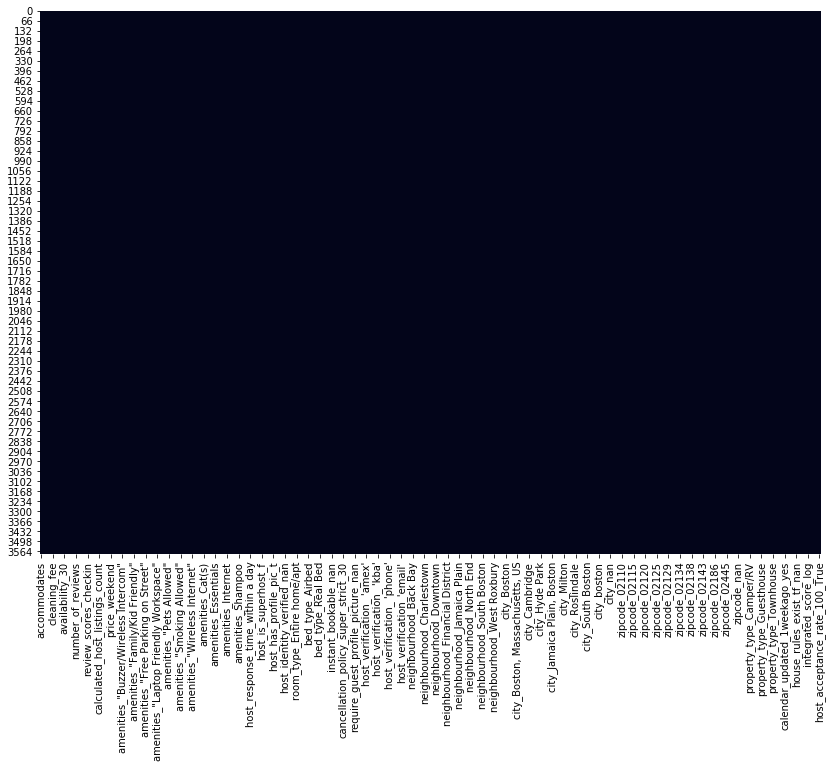

In [230]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_listing_modi2.isnull(), cbar=False)

In [231]:
check_null=list(df_listing_modi2.isnull().sum())
print(check_null)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [232]:
df_listing_modi2.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West E

In [233]:
# df_listing_modi2 = pd.get_dummies(df_listing_modi2, columns=['host_response_rate_100','host_acceptance_rate_100'], 
#                                   prefix=['host_response_rate_100','host_acceptance_rate_100'])
# df_listing_modi2.head()


In [234]:
print(df_listing_modi2.integrated_score_log.describe())
print(df_listing_modi2.integrated_score_log.quantile(0.8))
print(df_listing_modi2.integrated_score_log.quantile(0.2))
threshold_80 = df_listing_modi2.integrated_score_log.quantile(0.8)
# df_listing_modi2['y_label'] = df_listing_modi2

count    3585.000000
mean        5.325527
std         3.041916
min         0.000000
25%         4.531703
50%         6.175867
75%         7.566828
max        10.358155
Name: integrated_score_log, dtype: float64
7.836368513676909
0.0


(array([756.,   0.,   0.,   0.,   0.,   5.,   0.,  25., 356.,  63., 305.,
        303., 330., 329., 356., 299., 223., 140.,  71.,  24.]),
 array([ 0.    ,  0.5179,  1.0358,  1.5537,  2.0716,  2.5895,  3.1074,
         3.6254,  4.1433,  4.6612,  5.1791,  5.697 ,  6.2149,  6.7328,
         7.2507,  7.7686,  8.2865,  8.8044,  9.3223,  9.8402, 10.3582]),
 <a list of 20 Patch objects>)

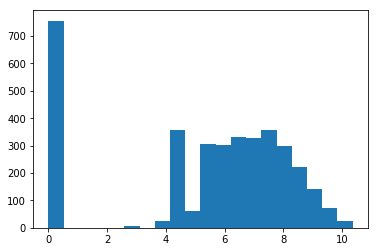

In [235]:
plt.hist(df_listing_modi2.integrated_score_log,bins=20)

In [236]:
condition = [df_listing_modi2['integrated_score_log'] == 0, df_listing_modi2['integrated_score_log'] >= threshold_80]
label_list = ['poor','high']


df_listing_modi2['y_label'] = np.select(condition, label_list, default='normal')

df_listing_modi2.head(n=10)



,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West E

In [237]:
df_listing_modi3 =  df_listing_modi2.drop(['integrated_score_log','number_of_reviews','review_scores_rating', 'review_scores_value',
                                          'review_scores_communication','review_scores_accuracy','review_scores_checkin','review_scores_cleanliness',
                                          'review_scores_location', 'availability_30','availability_60', 'availability_90','availability_365','calculated_host_listings_count'], axis=1)


In [238]:
df_listing_modi3.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [239]:
# Store the 'y_label' feature in a new variable and remove it from the dataset
target = df_listing_modi3['y_label']
df_listing_modi3 = df_listing_modi3.drop('y_label', axis = 1)

In [240]:
df_listing_modi3.head(n=3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [241]:
X_train, X_test, y_train, y_test = train_test_split(df_listing_modi3, target, test_size=0.3, random_state=42)

In [242]:
print(X_train.shape)
print(X_test.shape)

(2509, 255)
(1076, 255)


In [243]:
# TODO: Define the classifier, and fit it to the data
c_parameter_name = 'min_samples_leaf'
c_parameter_values = [2,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,150,200]
train_list = []
test_list = []

for i in c_parameter_values:
    model = RandomForestClassifier(n_estimators=200, min_samples_leaf=i, max_features='auto',
                                   max_depth=15, bootstrap=True)
    model.fit(X_train, y_train)
    # Making predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_list.append(train_accuracy)
    test_list.append(test_accuracy)
#     print('The training accuracy is', train_accuracy)
#     print('The test accuracy is', test_accuracy)

for j in zip(train_list, test_list):
    print(j)

# importances = model.feature_importances_ 
# print(len(importances))
# print()
# # print(importances)

# indices = np.argsort(importances)[::-1]
# columns = X_train.columns.values[indices[:25]]
# values = importances[indices][:25]

# tmp = 0
# for i,j in zip(columns, values):
#     print(i,j)
#     tmp += j
    
# print(tmp)

(0.9067357512953368, 0.7304832713754646)
(0.7971303308090872, 0.716542750929368)
(0.7373455559984058, 0.7044609665427509)
(0.7094459944200877, 0.6895910780669146)
(0.6879234754882423, 0.6830855018587361)
(0.6699880430450379, 0.6728624535315985)
(0.6560382622558788, 0.6635687732342007)
(0.6424870466321243, 0.6514869888475836)
(0.6400956556396971, 0.6533457249070632)
(0.629732961339179, 0.6366171003717472)
(0.6293343961737744, 0.6356877323420075)
(0.6245516141889199, 0.6347583643122676)
(0.6129932243921882, 0.6236059479553904)
(0.6066161817457154, 0.6198884758364313)
(0.6086090075727382, 0.6161710037174721)
(0.6078118772419291, 0.6189591078066915)
(0.5898764447987246, 0.6031598513011153)
(0.6014348345954563, 0.6152416356877324)
(0.5858907931446792, 0.6003717472118959)
(0.5870864886408927, 0.5994423791821561)
(0.5850936628138701, 0.5985130111524164)
(0.5850936628138701, 0.5985130111524164)
(0.5850936628138701, 0.5985130111524164)


In [244]:
# TODO: Define the classifier, and fit it to the data
model = RandomForestClassifier(n_estimators=110, min_samples_leaf=5, max_features=45,
                               max_depth=18, bootstrap=True, min_impurity_decrease=0.0001)
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_list.append(train_accuracy)
test_list.append(test_accuracy)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)


importances = model.feature_importances_ 
print(len(importances))
print()
# print(importances)

indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:15]]
values = importances[indices][:15]

tmp = 0
for i,j in zip(columns, values):
    print(i,j)
    tmp += j
    
print(tmp)

The training accuracy is 0.8409724990035871
The test accuracy is 0.7239776951672863
255

host_verification_ 'reviews' 0.12833216288423668
avail_days_weekdays 0.051835849711633186
unavail_days 0.05168526384850264
price_weekday 0.04659408726506716
price_weekend 0.04466182733527794
avail_days_weekends 0.041662748136972134
cleaning_fee 0.03488948256333109
host_is_superhost_t 0.024716597324206377
host_is_superhost_f 0.02170096654995027
minimum_nights 0.02167973864410593
host_response_time_nan 0.021479399037295215
maximum_nights 0.018793294266524863
host_response_time_within an hour 0.01832790763458321
house_rules_exist_tf_False 0.01706246664925255
house_rules_exist_tf_True 0.016656099771305388
0.5600778916222449


In [245]:
# TODO: Define the classifier, and fit it to the data
#  RandomForestClassifier,BaggingClassifier,AdaBoostClassifier, DecisionTreeClassifier
model = BaggingClassifier(n_estimators=400,bootstrap_features=True)
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

model.base_estimator_
# importances = model.feature_importances_ 
# print(len(importances))
# print()
# # print(importances)

# indices = np.argsort(importances)[::-1]
# columns = X_train.columns.values[indices[:15]]
# values = importances[indices][:15]

# tmp = 0
# for i,j in zip(columns, values):
#     print(i,j)
#     tmp += j
    
# print(tmp)

The training accuracy is 0.9996014348345954
The test accuracy is 0.7434944237918215


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## PCA

In [246]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
column_list = list(df_listing_modi3.columns)
scaled_values = scaler.fit_transform(df_listing_modi3.values)
df_listing_scaled = pd.DataFrame(scaled_values, index=df_listing_modi3.index, columns=df_listing_modi3.columns)
df_listing_scaled.shape

(3585, 255)

In [247]:
# Apply PCA to the data.
pca = PCA(n_components=200)
pca.fit(df_listing_scaled)

# Investigate the variance accounted for by each principal component.
tmp1 = 0
tmp2 = 0
for i in pca.explained_variance_ratio_:
    tmp1 += 1
    tmp2 += i
    print(tmp1, tmp2)
    if tmp2 > 0.9:
        break

1 0.03523668206792573
2 0.06635952398487684
3 0.08579671600015838
4 0.10262003866580398
5 0.11899218882405421
6 0.13358678369095042
7 0.14707150309992612
8 0.16040266389354518
9 0.1729600641178249
10 0.1847673727209544
11 0.1964524075946411
12 0.20799286461787134
13 0.21912756022657875
14 0.2299882054527537
15 0.24077516599105367
16 0.25116134590526057
17 0.26118426312115467
18 0.2710146594960715
19 0.2808343519681784
20 0.290387418758406
21 0.2997725317128755
22 0.30907076878247774
23 0.31821800158527463
24 0.3273350768134708
25 0.3363457179612183
26 0.3451704118532238
27 0.35378819517269416
28 0.3623212484559454
29 0.3706641185905187
30 0.37893938599925586
31 0.3871769805447808
32 0.3952704333644117
33 0.4033288114186601
34 0.4111208221363834
35 0.41878435246483275
36 0.42630150754663787
37 0.43380932821883444
38 0.4411837798652429
39 0.4484727044905862
40 0.4556085739407679
41 0.46262964627945924
42 0.46941653818944284
43 0.47618771514811714
44 0.48280733953253885
45 0.4893091553684

In [248]:
# Apply PCA to the data.
pca = PCA(n_components=142, random_state=42)
pca.fit(df_listing_scaled)

PCA(copy=True, iterated_power='auto', n_components=142, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [356]:
def investigate(df_listing_scaled, pca, i):
    pos_list =[]
    neg_list =[]
    feature_names = list(df_listing_scaled.columns)
    weights_pca = copy.deepcopy(pca.components_[i])
    combined = list(zip(feature_names, weights_pca))
    combined_sorted= sorted(combined, key=lambda tup: tup[1], reverse=True)
    tmp_list = [list(x) for x in combined_sorted]
    tmp_list = [(x[0],"{0:.3f}".format(x[1])) for x in tmp_list]
    print("positive to pca{}:".format(i), tmp_list[0:10])
    print()
    print("negative to pca{}:".format(i), tmp_list[-1:-11:-1])
    print()
    for j in range(0,10):
        pos_list.append(tmp_list[j][0])
    for k in range(1,11):
        neg_list.append(tmp_list[-k][0])
    
    return pos_list, neg_list
    

np.set_printoptions(precision=4)
investigate(df_listing_scaled, pca, 1)
investigate(df_listing_scaled, pca, 2)

positive to pca1: [('host_response_rate_100_True', '0.207'), ('host_response_time_within an hour', '0.196'), ('extra_people_fee_tf_True', '0.180'), ('amenities_"Carbon Monoxide Detector"', '0.170'), ('amenities_"Hair Dryer"', '0.161'), ('amenities_Hangers', '0.158'), ('calendar_updated_1weekago_yes', '0.158'), ('amenities_"Smoke Detector"', '0.155'), ('amenities_Shampoo', '0.154'), ('amenities_Iron', '0.152')]

negative to pca1: [('host_response_rate_100_False', '-0.207'), ('extra_people_fee_tf_False', '-0.180'), ('calendar_updated_1weekago_more_than_1week', '-0.158'), ('host_response_time_nan', '-0.154'), ('house_rules_exist_tf_False', '-0.149'), ('host_is_superhost_f', '-0.140'), ('host_acceptance_rate_100_False', '-0.134'), ('property_type_Apartment', '-0.118'), ('amenities_"Elevator in Building"', '-0.115'), ('cancellation_policy_flexible', '-0.109')]

positive to pca2: [('avail_days_weekends', '0.275'), ('avail_days_weekdays', '0.272'), ('require_guest_phone_verification_t', '0.22

(['avail_days_weekends',
  'avail_days_weekdays',
  'require_guest_phone_verification_t',
  'cancellation_policy_super_strict_30',
  'host_identity_verified_t',
  'require_guest_profile_picture_t',
  'host_response_time_within a few hours',
  "host_verification_ 'reviews'",
  'house_rules_exist_tf_True',
  "host_verification_ 'phone'"],
 ['unavail_days',
  'require_guest_phone_verification_f',
  'amenities_Hangers',
  'amenities_"Laptop Friendly Workspace"',
  'amenities_"Hair Dryer"',
  'amenities_Iron',
  'host_identity_verified_f',
  'require_guest_profile_picture_f',
  'amenities_Essentials',
  'host_response_time_nan'])

In [357]:
df_listing_scaled_transformed = pca.fit_transform(df_listing_scaled)
df_listing_scaled_transformed = pd.DataFrame(df_listing_scaled_transformed)

In [325]:
X_train, X_test, y_train, y_test = train_test_split(df_listing_scaled_transformed, target, test_size=0.3, random_state=42)

In [252]:
print(X_train.shape)
print(X_test.shape)
X_train.head()

(2509, 142)
(1076, 142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
2609,0.489849,2.489654,2.522341,-2.199335,-0.615287,2.551660,-1.805637,-4.405537,2.858187,-2.299375,-2.660087,4.866105,2.506749,-0.545654,-3.479527,-0.866859,-0.156439,-4.155935,2.136181,0.011564,0.620264,5.422276,0.188977,0.104036,0.337592,-0.979501,1.278886,0.963666,-1.618375,2.100241,-2.150188,-2.328156,0.408054,0.611357,-0.966398,0.007029,-0.986036,-1.519321,-0.766618,-2.879137,2.135141,-0.835493,-1.078435,1.174038,1.641335,-0.338215,0.587620,0.114203,-1.434856,-0.604542,0.912597,-1.120941,-1.748255,0.081316,1.683875,2.011780,2.605779,0.334479,4.496547,1.088815,-0.745946,2.005692,-0.130270,-0.440111,-0.786398,-2.102808,1.044372,-0.267248,-2.293844,-0.035934,-1.323506,1.380173,-0.462987,-0.565216,1.600341,0.732988,-1.511422,-0.608682,0.250496,0.000962,-0.092436,0.734653,0.046860,-0.467550,-0.090655,-0.156171,0.089985,-0.043219,0.111705,-0.047700,0.049674,0.319223,-0.133957,-0.554552,0.633977,-0.057566,0.406470,-0.329101,0.402878,-0.092484,-0.351471,0.959311,0.538644,0.180797,-0.773480,1.048847,-0.206266,1.167151,-1.185200,-0.851089,0.538600,2.219764,0.217416,-0.967333,0.711272,-1.257049,-0.462993,0.709888,2.828666,-1.355564,-1.993498,1.025959,1.927767,-0.978959,0.412188,0.671091,0.223146,0.210557,-0.926185,0.903777,0.395528,0.623304,-1.025981,-0.538647,0.268599,0.903521,0.365805,1.063757,-0.096594,-0.020840,-0.070425,0.811088
2014,2.425256,-1.878042,1.525350,0.615482,1.107517,-2.345880,0.392913,-0.225571,-0.131671,-0.211679,1.460614,-0.966207,-0.557517,-0.002269,-0.575427,0.647102,0.477338,0.372680,0.919293,0.079983,0.261233,-0.071007,1.638190,0.225515,1.619458,1.465354,-0.208700,1.018299,-2.660337,-0.732640,0.611241,2.317609,-1.762581,0.147180,-0.260995,0.239084,-0.714924,1.669641,1.045890,0.192388,-0.430234,-0.381500,-1.410986,-0.226213,-0.703147,-0.725523,-0.336191,1.265060,0.035081,0.446340,-0.381739,0.085219,-0.545519,-0.388070,0.055938,0.138164,-0.463554,0.048983,-0.193884,-1.050496,0.088021,0.090922,-0.477717,0.361047,-0.905025,-0.073906,-0.630458,0.615488,-0.362001,0.353731,-0.517487,0.270541,0.427550,-0.195471,0.054187,0.819231,0.501893,-0.329417,0.599021,-0.306424,-0.180498,0.236691,-0.024664,0.215079,0.327179,-0.280057,-0.377254,0.078580,-0.126362,-0.298771,-0.022772,-0.010645,0.147239,0.138938,0.056211,-0.038588,0.049627,0.694981,-0.437922,0.445388,0.145062,0.085780,0.154892,-0.539474,-0.489810,0.931705,-0.855310,0.167566,0.631922,0.052352,0.241632,-0.174890,0.480889,0.010201,0.092025,-0.375153,-0.032345,-0.607219,0.865624,-0.033393,-0.028692,-0.775458,0.405914,0.221739,-0.511342,0.048220,-0.138976,-1.699905,0.506177,0.406285,0.224509,-0.022659,-0.152930,0.340923,-0.296351,-0.489599,0.752235,-0.686934,-0.511200,1.177888,-0.425547,-0.270918
407,-1.736958,-1.928621,-0.478313,0.182921,0.348769,-0.598622,-1.553939,-0.136751,-0.044794,1.123705,0.610795,-0.620917,0.425160,-1.038064,1.252512,-0.257853,-1.593635,-2.537025,2.887915,2.417154,3.063711,-2.360611,-0.663457,0.022025,-1.219703,0.682617,2.453533,0.824531,-0.457369,-0.730591,1.008369,0.331571,0.074291,-1.491674,0.935724,-0.060403,-0.036720,0.118106,-0.925252,-0.474737,0.291226,0.048912,-0.398483,1.033849,-0.319194,-1.661712,0.134354,1.514574,-0.590705,-0.504116,-0.574772,-1.039400,0.815358,-0.573584,-1.247400,-0.744227,-1.543424,0.186103,0.505572,0.047812,-1.053766,1.280532,0.221788,-0.745093,0.181565,0.779515,0.480624,0.963997,-0.867506,0.689446,-0.350692,-0.186853,-0.067575,0.789046,0.278408,-0.298064,-0.255251,0.109794,0.126375,-0.455946,-0.242743,-0.215742,-0.056297,-0.469519,0.413937,0.626253,0.172606,0.138

In [253]:
# TODO: Define the classifier, and fit it to the data
model = RandomForestClassifier(n_estimators=200, min_samples_split=5, min_samples_leaf=5, max_features=20,
                               max_depth=10, bootstrap=False)
model.fit(X_train, y_train)
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

importances = model.feature_importances_ 
print(len(importances))
print()
# print(importances)

indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:10]]
values = importances[indices][:10]

tmp = 0
for i,j in zip(columns, values):
    print(i,j)
    tmp += j
    
print(tmp)

The training accuracy is 0.912714228776405
The test accuracy is 0.6840148698884758
142

1 0.12028423454713984
2 0.03203502478697457
61 0.018272186470423352
5 0.017380097750931918
40 0.015426751470526533
29 0.013232157604572465
19 0.012744488009595704
9 0.012597961554433068
51 0.012150362782502788
133 0.011830695444938725
0.26595396042203895


In [254]:
print(df_listing_scaled_transformed.shape)
df_listing_scaled_transformed.head()

(3585, 142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
0,-1.332913,-0.924302,-0.088032,-2.832177,4.937275,2.379668,1.339706,0.535252,-0.795056,0.127097,-0.196954,-0.177570,-0.455775,0.139454,-0.213802,-0.225797,3.271111,3.030547,-0.508252,-2.123022,2.359935,0.101058,-2.646816,-0.850055,-3.700195,1.270303,0.661373,4.133362,-0.051895,-2.157198,-4.570852,0.478559,-0.955072,1.557406,-1.115219,-0.556854,-0.835601,-0.343742,0.409942,-0.198423,1.040546,-0.026697,0.511416,-0.007506,-0.224547,0.159042,0.053141,-0.614561,0.853760,-1.000340,0.073125,0.965495,-0.755720,-0.036202,1.069006,-0.729859,-0.231508,0.263039,-0.787003,0.104943,-0.700986,1.153031,-0.097875,0.132629,-0.148538,-0.667779,-0.148185,0.952405,-0.067528,0.042388,0.216674,-0.170199,-0.372080,1.004713,-0.497062,0.523010,-0.932122,0.331602,-0.457168,0.316197,-0.018754,0.033527,-0.103253,0.867450,-1.494938,-0.890819,0.106805,-0.516197,-0.298356,-0.374586,0.439233,-0.341768,-0.138144,-0.195024,-0.261939,-0.053512,0.254018,-0.516775,-0.894395,0.527460,-0.843149,0.290402,-0.701526,1.307748,0.304554,-0.681869,0.025993,1.307136,1.070907,-0.635127,1.007163,-0.680336,-0.371976,-0.774546,0.832741,-0.281024,-0.607965,-0.405383,0.084837,-0.756040,0.337328,-0.017684,0.376885,-0.039586,0.969886,1.156029,-1.906684,0.600693,0.286179,0.984301,1.140446,0.552722,1.222202,0.196671,-0.258862,1.000917,-2.947904,-0.676585,-0.163052,0.706125,-0.892724,-0.758235
1,-1.673873,4.565411,0.957412,-0.530512,-1.665187,0.665176,0.130102,0.228968,-0.110520,2.660308,-1.253747,-0.333063,0.099411,-0.113477,1.251118,-1.264650,3.718714,3.190404,2.019505,-3.164663,0.360220,-0.400607,-3.811957,-1.204317,-4.923925,-0.517620,1.279373,3.648595,-0.724433,-3.661825,-1.507903,1.902403,-1.026652,2.122136,-1.698435,-0.474733,-1.423924,1.759268,-0.553547,1.432256,-0.086027,-0.793865,-0.486047,-1.191009,2.143809,-0.216469,-0.034539,-0.059132,1.608445,-2.281038,1.725784,2.380926,-0.840973,1.271857,0.058630,-1.724065,-1.968724,-0.733751,0.369222,-1.040725,-1.978518,0.425309,0.117984,0.533346,0.069771,-1.110529,0.864077,0.716847,0.061312,0.476451,-1.800379,-0.303349,-0.186526,1.921911,-0.142218,-0.587688,0.091885,0.425895,-0.031466,-0.433011,0.504527,-1.539968,0.055984,0.187405,-2.258998,-0.065751,0.542521,-0.057467,-0.238951,-0.626584,0.448876,-0.620047,0.231457,-0.002048,-0.585407,-0.513474,-0.118427,-0.511645,-1.067549,0.071905,-0.411950,-0.261858,-0.660754,1.586430,-0.257748,-0.940338,-0.312579,0.613177,1.454804,0.501034,-0.014458,-0.911934,-1.444849,0.103338,0.242610,0.834872,-0.535923,0.370343,0.488242,-0.025759,0.105760,-0.938535,1.833640,2.511565,1.963837,0.086394,-2.573546,0.471615,0.243081,1.549942,0.639391,-0.164706,0.508519,0.981804,0.194724,-0.645505,-1.584655,1.428004,0.194012,0.268638,-1.748827,-2.202052
2,-2.036351,3.504621,6.112145,-3.306885,-0.249315,0.245860,-2.222537,-2.495976,2.074228,0.096501,0.325221,-0.643353,-0.009130,-0.848107,0.482458,0.085402,3.365286,-0.790791,0.150854,-5.888296,3.249810,0.372888,-0.255789,-2.158821,-4.425897,1.457960,1.934620,1.978038,-0.884027,0.688519,-4.277530,-0.399525,-0.574108,1.683775,-0.447975,-2.564048,2.614356,-2.459639,1.237916,-0.925229,-0.452122,0.179599,0.410937,1.443120,1.171491,0.540412,0.345737,-2.327187,-1.851988,-2.208875,1.634109,2.103205,-0.810608,-0.137360,0.317875,-0.044745,-0.237205,-0.533328,0.201535,0.481678,-1.191307,1.830795,0.279533,0.596680,-0.405053,0.435283,1.472477,0.875432,-0.812160,0.583300,-1.231465,0.094961,-0.084185,0.902061,-0.035509,0.548514,-0.076147,0.178298,0.607027,-0.467770,-0.134772,0.107090,0.201861,0.514701,-1.044201,-0.381131,-0.431819,

In [255]:
new_df = pd.concat([df_listing_scaled_transformed, target], axis=1)

In [256]:
new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,y_label
0,-1.332913,-0.924302,-0.088032,-2.832177,4.937275,2.379668,1.339706,0.535252,-0.795056,0.127097,-0.196954,-0.177570,-0.455775,0.139454,-0.213802,-0.225797,3.271111,3.030547,-0.508252,-2.123022,2.359935,0.101058,-2.646816,-0.850055,-3.700195,1.270303,0.661373,4.133362,-0.051895,-2.157198,-4.570852,0.478559,-0.955072,1.557406,-1.115219,-0.556854,-0.835601,-0.343742,0.409942,-0.198423,1.040546,-0.026697,0.511416,-0.007506,-0.224547,0.159042,0.053141,-0.614561,0.853760,-1.000340,0.073125,0.965495,-0.755720,-0.036202,1.069006,-0.729859,-0.231508,0.263039,-0.787003,0.104943,-0.700986,1.153031,-0.097875,0.132629,-0.148538,-0.667779,-0.148185,0.952405,-0.067528,0.042388,0.216674,-0.170199,-0.372080,1.004713,-0.497062,0.523010,-0.932122,0.331602,-0.457168,0.316197,-0.018754,0.033527,-0.103253,0.867450,-1.494938,-0.890819,0.106805,-0.516197,-0.298356,-0.374586,0.439233,-0.341768,-0.138144,-0.195024,-0.261939,-0.053512,0.254018,-0.516775,-0.894395,0.527460,-0.843149,0.290402,-0.701526,1.307748,0.304554,-0.681869,0.025993,1.307136,1.070907,-0.635127,1.007163,-0.680336,-0.371976,-0.774546,0.832741,-0.281024,-0.607965,-0.405383,0.084837,-0.756040,0.337328,-0.017684,0.376885,-0.039586,0.969886,1.156029,-1.906684,0.600693,0.286179,0.984301,1.140446,0.552722,1.222202,0.196671,-0.258862,1.000917,-2.947904,-0.676585,-0.163052,0.706125,-0.892724,-0.758235,poor
1,-1.673873,4.565411,0.957412,-0.530512,-1.665187,0.665176,0.130102,0.228968,-0.110520,2.660308,-1.253747,-0.333063,0.099411,-0.113477,1.251118,-1.264650,3.718714,3.190404,2.019505,-3.164663,0.360220,-0.400607,-3.811957,-1.204317,-4.923925,-0.517620,1.279373,3.648595,-0.724433,-3.661825,-1.507903,1.902403,-1.026652,2.122136,-1.698435,-0.474733,-1.423924,1.759268,-0.553547,1.432256,-0.086027,-0.793865,-0.486047,-1.191009,2.143809,-0.216469,-0.034539,-0.059132,1.608445,-2.281038,1.725784,2.380926,-0.840973,1.271857,0.058630,-1.724065,-1.968724,-0.733751,0.369222,-1.040725,-1.978518,0.425309,0.117984,0.533346,0.069771,-1.110529,0.864077,0.716847,0.061312,0.476451,-1.800379,-0.303349,-0.186526,1.921911,-0.142218,-0.587688,0.091885,0.425895,-0.031466,-0.433011,0.504527,-1.539968,0.055984,0.187405,-2.258998,-0.065751,0.542521,-0.057467,-0.238951,-0.626584,0.448876,-0.620047,0.231457,-0.002048,-0.585407,-0.513474,-0.118427,-0.511645,-1.067549,0.071905,-0.411950,-0.261858,-0.660754,1.586430,-0.257748,-0.940338,-0.312579,0.613177,1.454804,0.501034,-0.014458,-0.911934,-1.444849,0.103338,0.242610,0.834872,-0.535923,0.370343,0.488242,-0.025759,0.105760,-0.938535,1.833640,2.511565,1.963837,0.086394,-2.573546,0.471615,0.243081,1.549942,0.639391,-0.164706,0.508519,0.981804,0.194724,-0.645505,-1.584655,1.428004,0.194012,0.268638,-1.748827,-2.202052,high
2,-2.036351,3.504621,6.112145,-3.306885,-0.249315,0.245860,-2.222537,-2.495976,2.074228,0.096501,0.325221,-0.643353,-0.009130,-0.848107,0.482458,0.085402,3.365286,-0.790791,0.150854,-5.888296,3.249810,0.372888,-0.255789,-2.158821,-4.425897,1.457960,1.934620,1.978038,-0.884027,0.688519,-4.277530,-0.399525,-0.574108,1.683775,-0.447975,-2.564048,2.614356,-2.459639,1.237916,-0.925229,-0.452122,0.179599,0.410937,1.443120,1.171491,0.540412,0.345737,-2.327187,-1.851988,-2.208875,1.634109,2.103205,-0.810608,-0.137360,0.317875,-0.044745,-0.237205,-0.533328,0.201535,0.481678,-1.191307,1.830795,0.279533,0.596680,-0.405053,0.435283,1.472477,0.875432,-0.812160,0.583300,-1.231465,0.094961,-0.084185,0.902061,-0.035509,0.548514,-0.076147,0.178298,0.607027,-0.467770,-0.134772,0.107090,0.201861,0.514701,-1.044201,-0

In [257]:
new_df_poor = new_df[new_df.y_label == 'poor']
new_df_high = new_df[new_df.y_label == 'high']

In [258]:
new_df_poor.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.042914,-1.582448,-0.814532,0.274745,-0.063947,0.644539,-0.029592,0.278939,-0.119955,0.135075,0.062266,-0.062018,0.001446,0.233493,-0.156374,-0.272885,0.093739,-0.196562,0.095609,-0.037485,0.100153,0.035729,0.256589,0.033095,-0.176357,-0.218149,0.104616,-0.002498,0.006821,0.186267,-0.092359,0.080199,0.032237,-0.009606,0.064991,-0.018817,0.091065,-0.081029,-0.089408,0.076351,-0.068980,0.092267,-0.020960,-0.050216,-0.014150,0.106766,-0.059165,0.005014,0.016522,-0.115251,0.108997,0.068241,-0.115483,-0.004792,0.087483,-0.147488,-0.195567,-0.052431,-0.000525,-0.142552,-0.049326,0.211073,0.021890,0.056608,0.045109,0.076105,0.026959,0.040977,0.013895,-0.065127,0.029688,0.039826,-0.047607,-0.068644,0.040666,0.006921,-0.034210,-0.114007,-0.103640,-0.025916,-0.067457,-0.009129,-0.000991,0.010487,0.038315,0.062665,0.018180,0.002484,0.006222,0.051663,-0.082223,-0.035022,-0.008808,0.022287,0.021847,-0.033857,0.062831,-0.080676,-0.062728,0.073931,-0.058688,0.021397,0.050608,0.001041,-0.032956,-0.011799,-0.008178,0.020623,0.058946,-0.025866,-0.045975,0.053639,0.089106,-0.043868,0.038345,-0.051375,0.081464,0.010078,-0.014319,0.051237,-0.110328,0.039208,-0.123557,-0.059852,-0.026155,-0.032136,0.003239,0.063230,-0.002148,-0.006928,-0.016298,-0.051116,-0.030402,0.108703,-0.002450,-0.104442,0.019709,-0.034042,0.140097,-0.045309,0.131288,-0.033809
std,3.293232,2.638485,2.100116,2.208508,2.061301,2.156942,2.609389,2.052906,3.143811,2.289273,2.231104,2.010035,2.702136,2.501503,1.765229,1.741526,1.551195,1.348725,1.733340,1.508050,1.561624,1.449236,1.312131,1.488605,1.421091,1.449007,1.307429,1.060824,1.327290,1.104114,1.245813,1.425999,1.505771,1.375734,1.558052,1.705393,1.844724,1.670269,1.571846,1.482993,1.657797,1.292724,1.362735,1.753725,1.685190,1.532045,1.258134,1.454862,1.402575,1.353306,1.506270,1.310641,1.209099,1.245727,1.192197,1.286422,1.170511,1.200902,1.190260,1.144150,1.226717,1.129394,1.207933,1.248729,1.107073,1.153083,1.153583,1.161134,1.

In [259]:
new_df_high.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141
count,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,-0.187798,2.048677,0.809411,-0.080822,0.007457,-0.342508,-0.148508,-0.119438,0.262644,0.005537,-0.122376,0.090065,0.145072,-0.036441,0.223752,0.110172,0.193555,0.088781,0.089769,-0.214997,0.062441,0.036381,-0.170173,-0.174488,-0.038091,0.083957,-0.152259,-0.234964,0.023095,0.044845,0.133301,-0.053583,-0.069684,0.030485,-0.075396,0.047930,0.095420,0.130474,-0.030126,-0.059105,-0.230094,0.145256,-0.114834,0.087827,-0.083233,-0.087855,0.088296,-0.046292,0.040481,-0.006546,-0.060497,-0.224805,0.068446,0.005850,0.180679,-0.037168,0.081423,0.014322,-0.029104,0.015891,0.054899,0.106526,0.027383,0.027987,-0.040260,0.084948,0.004069,0.064662,-0.050561,-0.087229,0.065073,-0.031842,0.006206,0.039066,-0.058338,-0.067288,-0.077303,0.008243,0.115626,0.049226,0.054979,-0.047591,0.058849,-0.004187,0.006028,-0.014097,-0.020748,-0.005530,-0.012665,-0.029506,0.006400,0.007409,0.009380,-0.022319,-0.026603,-0.038735,0.045951,0.025947,-0.029358,-0.034062,0.005259,-0.049368,0.027838,-0.011616,0.036623,0.014668,0.037590,-0.012825,-0.013571,-0.028894,0.024637,0.026371,0.030213,0.033005,-0.003791,-0.032500,0.036832,0.014134,0.007573,0.037920,-0.000949,-0.006789,0.030487,-0.015537,0.004072,-0.059700,0.063687,-0.023564,0.054388,-0.036270,0.002641,-0.021923,-0.004551,0.007006,0.050815,0.013470,0.014837,-0.070674,0.010573,0.022885,-0.030004,0.026707
std,2.411789,2.267798,2.083761,1.968572,1.723040,1.626613,1.234078,1.574657,1.156147,1.233208,1.386525,1.462139,1.019379,0.997022,1.559172,1.454208,1.700595,1.794931,1.461016,1.697360,1.490530,1.528506,1.691644,1.554653,1.535137,1.520551,1.521492,1.419014,1.304600,1.312529,1.432624,1.595031,1.329561,1.448587,1.450187,1.291846,1.193444,1.269799,1.400117,1.264019,1.299882,1.404797,1.312674,1.153311,1.210941,1.129562,1.260949,1.197178,1.355521,1.205429,1.203377,1.206014,1.271157,1.314868,1.276056,1.202921,1.156901,1.281575,1.105723,1.281526,1.141309,1.204756,1.250727,1.080401,1.253140,1.188410,1.060129,1.077801,0.987052,1

In [260]:
poor_array = new_df_poor.describe().iloc[1:2].to_numpy().flatten()

In [261]:
high_array = new_df_high.describe().iloc[1:2].to_numpy().flatten()

In [262]:
df_compare = pd.DataFrame()
df_compare['poor'] = poor_array
df_compare['high'] = high_array
df_compare['difference'] = df_compare['poor'] - df_compare['high']
df_compare['difference'] = df_compare['difference'].abs()
df_compare.sort_values(by=['difference'], ascending=False).head(n=10)

,poor,high,difference
1,-1.582448,2.048677,3.631126
2,-0.814532,0.809411,1.623943
5,0.644539,-0.342508,0.987047
22,0.256589,-0.170173,0.426762
7,0.278939,-0.119438,0.398377
15,-0.272885,0.110172,0.383057
8,-0.119955,0.262644,0.382598
14,-0.156374,0.223752,0.380126
3,0.274745,-0.080822,0.355568
25,-0.218149,0.083957,0.302106


In [263]:
def compare_columns(new_df_poor,new_df_high):
    columns_compared = [1,2,5,22,7]
    
    for i in columns_compared:
        poor_group = new_df_poor[i].dropna().values
        high_group = new_df_high[i].dropna().values
        oneway_result = stats.f_oneway(poor_group, high_group)
        print(oneway_result)
        
compare_columns(new_df_poor,new_df_high)

F_onewayResult(statistic=798.5036573875428, pvalue=1.087173540413429e-140)
F_onewayResult(statistic=221.71000906698, pvalue=8.206730439037517e-47)
F_onewayResult(statistic=97.53704634977996, pvalue=2.567993768764777e-22)
F_onewayResult(statistic=29.439487806447836, pvalue=6.737129402698684e-08)
F_onewayResult(statistic=17.3299996212864, pvalue=3.3241197836090354e-05)


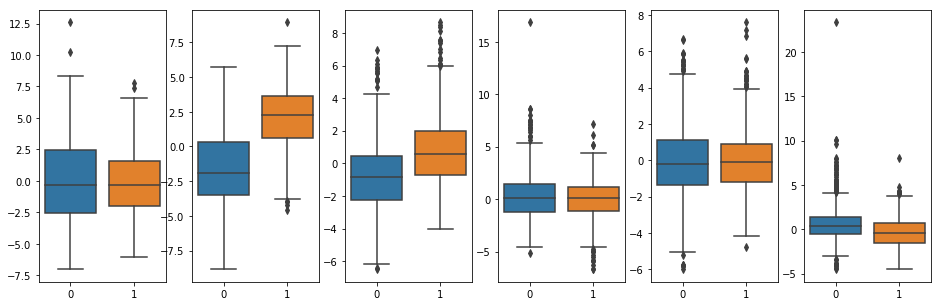

In [302]:
figure, axes = plt.subplots(1, 6, figsize=(16,5))
ax0 = sns.boxplot(data=[new_df_poor[0],new_df_high[0]], ax=axes[0])
ax1 = sns.boxplot(data=[new_df_poor[1],new_df_high[1]], ax=axes[1])
ax2 = sns.boxplot(data=[new_df_poor[2],new_df_high[2]], ax=axes[2])
ax3 = sns.boxplot(data=[new_df_poor[3],new_df_high[3]], ax=axes[3])
ax4 = sns.boxplot(data=[new_df_poor[4],new_df_high[4]], ax=axes[4])
ax5 = sns.boxplot(data=[new_df_poor[5],new_df_high[5]], ax=axes[5])

In [265]:
# Inverse transform to get original customers' dataframe  
pca_inversed = pca.inverse_transform(df_listing_scaled_transformed.to_numpy())
original_no_target = scaler.inverse_transform(pca_inversed) 
frame_inversed= pd.DataFrame(original_no_target, index=df_listing_modi3.index, columns=df_listing_modi3.columns)
frame_inversed.describe()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [266]:
frame_inversed.head(n=3)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [268]:
restore_df_listing = pd.concat([df_listing_modi3, target], axis=1)
restore_df_listing.head()

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [269]:
restore_df_listing_poor = restore_df_listing[restore_df_listing.y_label == 'poor']
restore_df_listing_high = restore_df_listing[restore_df_listing.y_label == 'high']

In [ ]:
# PCA1 : 
pca1_pos = ['host_response_rate_100_True', 'host_response_time_within an hour','extra_people_fee_tf_True', ]
positive to pca1: [('host_response_rate_100_True', '0.207'), ('host_response_time_within an hour', '0.196'), ('extra_people_fee_tf_True', '0.180'),
                   ('amenities_"Carbon Monoxide Detector"', '0.170'), ('amenities_"Hair Dryer"', '0.161'), ('amenities_Hangers', '0.158'), ('calendar_updated_1weekago_yes', '0.158'), ('amenities_"Smoke Detector"', '0.155'), ('amenities_Shampoo', '0.154'), ('amenities_Iron', '0.152')]

negative to pca1: [('host_response_rate_100_False', '-0.207'), ('extra_people_fee_tf_False', '-0.180'), ('calendar_updated_1weekago_more_than_1week', '-0.158'), ('host_response_time_nan', '-0.154'), ('house_rules_exist_tf_False', '-0.149'), ('host_is_superhost_f', '-0.140'), ('host_acceptance_rate_100_False', '-0.134'), ('property_type_Apartment', '-0.118'), ('amenities_"Elevator in Building"', '-0.115')]

In [273]:
restore_df_listing_poor['host_response_rate_100_True'].mean()

0.38095238095238093

In [274]:
restore_df_listing_high['host_response_rate_100_True'].mean()

0.8131101813110181

In [358]:
pos_list_1, neg_list_1 = investigate(df_listing_scaled, pca, 1)
pos_list_2, neg_list_2 =  investigate(df_listing_scaled, pca, 2)
pos_list_5, neg_list_5 =  investigate(df_listing_scaled, pca, 5)

positive to pca1: [('host_response_rate_100_True', '0.207'), ('host_response_time_within an hour', '0.196'), ('extra_people_fee_tf_True', '0.180'), ('amenities_"Carbon Monoxide Detector"', '0.170'), ('amenities_"Hair Dryer"', '0.161'), ('amenities_Hangers', '0.158'), ('calendar_updated_1weekago_yes', '0.158'), ('amenities_"Smoke Detector"', '0.155'), ('amenities_Shampoo', '0.154'), ('amenities_Iron', '0.152')]

negative to pca1: [('host_response_rate_100_False', '-0.207'), ('extra_people_fee_tf_False', '-0.180'), ('calendar_updated_1weekago_more_than_1week', '-0.158'), ('host_response_time_nan', '-0.154'), ('house_rules_exist_tf_False', '-0.149'), ('host_is_superhost_f', '-0.140'), ('host_acceptance_rate_100_False', '-0.134'), ('property_type_Apartment', '-0.118'), ('amenities_"Elevator in Building"', '-0.115'), ('cancellation_policy_flexible', '-0.109')]

positive to pca2: [('avail_days_weekends', '0.275'), ('avail_days_weekdays', '0.272'), ('require_guest_phone_verification_t', '0.22

In [359]:
data_pos_1 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_1]
data_neg_1 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_1]
tmp_pos_1 = pd.DataFrame(data=data_pos_1 , index=pos_list_1, columns=['high', 'poor'])
tmp_neg_1 = pd.DataFrame(data=data_neg_1 , index=neg_list_1, columns=['high', 'poor'])
tmp_both_1 = pd.concat([tmp_pos_1, tmp_neg_1])
tmp_both_1["difference"] = tmp_both.high - tmp_both.poor

In [366]:
tmp_both_1.sort_values(by=['difference'], ascending=False)

,high,poor,difference
host_response_rate_100_True,0.813110,0.380952,0.432158
host_response_time_within an hour,0.629010,0.257937,0.371073
extra_people_fee_tf_True,0.562064,0.212963,0.349101
calendar_updated_1weekago_yes,0.698745,0.462963,0.235782
"amenities_""Carbon Monoxide Detector""",0.786611,0.558201,0.228410
"amenities_""Smoke Detector""",0.881450,0.702381,0.179070
amenities_Shampoo,0.769874,0.656085,0.113790
"amenities_""Hair Dryer""",0.564854,0.496032,0.068822
amenities_Iron,0.542538,0.513228,0.029311
amenities_Hangers,0.556485,0.552910,0.003575


In [363]:
data_pos_2 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_2]
data_neg_2 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_2]
tmp_pos_2 = pd.DataFrame(data=data_pos_2 , index=pos_list_2, columns=['high', 'poor'])
tmp_neg_2 = pd.DataFrame(data=data_neg_2 , index=neg_list_2, columns=['high', 'poor'])
tmp_both_2 = pd.concat([tmp_pos_2, tmp_neg_2])
tmp_both_2["difference"] = tmp_both_2.high - tmp_both_2.poor

In [365]:
tmp_both_2.sort_values(by=['difference'], ascending=False)

,high,poor,difference
avail_days_weekdays,168.202232,109.603175,58.599057
avail_days_weekends,65.232915,43.678571,21.554343
house_rules_exist_tf_True,0.867503,0.445767,0.421736
host_verification_ 'reviews',1.000000,0.682540,0.317460
host_identity_verified_t,0.864714,0.583333,0.281381
"amenities_""Hair Dryer""",0.564854,0.496032,0.068822
require_guest_profile_picture_t,0.061367,0.002646,0.058721
require_guest_phone_verification_t,0.087866,0.035714,0.052152
host_verification_ 'phone',0.995816,0.953704,0.042112
amenities_Iron,0.542538,0.513228,0.029311


In [367]:
data_pos_5 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_5]
data_neg_5 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_5]
tmp_pos_5 = pd.DataFrame(data=data_pos_5 , index=pos_list_5, columns=['high', 'poor'])
tmp_neg_5 = pd.DataFrame(data=data_neg_5 , index=neg_list_5, columns=['high', 'poor'])
tmp_both_5 = pd.concat([tmp_pos_5, tmp_neg_5])
tmp_both_5["difference"] = tmp_both_5.high - tmp_both_5.poor

In [368]:
tmp_both_5.sort_values(by=['difference'], ascending=False)

,high,poor,difference
host_response_rate_100_True,0.813110,0.380952,0.432158
property_type_House,0.242678,0.107143,0.135535
cancellation_policy_strict,0.495119,0.383598,0.111521
"amenities_""Free Parking on Premises""",0.298466,0.187831,0.110635
require_guest_phone_verification_t,0.087866,0.035714,0.052152
neighbourhood_Beacon Hill,0.059972,0.025132,0.034840
neighbourhood_South End,0.083682,0.060847,0.022835
city_Boston,0.924686,0.927249,-0.002562
host_verification_ 'manual_online',0.011158,0.017196,-0.006038
city_Cambridge,0.001395,0.013228,-0.011833


In [416]:
pos_list_0, neg_list_0 = investigate(df_listing_scaled, pca, 0)
data_pos_0 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_0]
data_neg_0 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_0]
tmp_pos_0 = pd.DataFrame(data=data_pos_0 , index=pos_list_0, columns=['high', 'poor'])
tmp_neg_0 = pd.DataFrame(data=data_neg_0 , index=neg_list_0, columns=['high', 'poor'])
tmp_both_0 = pd.concat([tmp_pos_0, tmp_neg_0])
tmp_both_0["difference"] = tmp_both_0.high - tmp_both_0.poor
tmp_both_0.sort_values(by=['difference'], ascending=False)

positive to pca0: [('room_type_Entire home/apt', '0.240'), ('price_weekday', '0.231'), ('price_weekend', '0.230'), ('accommodates', '0.205'), ('amenities_"Cable TV"', '0.175'), ('cleaning_fee', '0.174'), ('amenities_Gym', '0.172'), ('amenities_"Elevator in Building"', '0.170'), ('amenities_TV', '0.166'), ('beds', '0.154')]

negative to pca0: [('room_type_Private room', '-0.228'), ('cancellation_policy_flexible', '-0.126'), ('require_guest_phone_verification_f', '-0.106'), ('host_identity_verified_f', '-0.096'), ('property_type_House', '-0.096'), ('amenities_"Lock on Bedroom Door"', '-0.089'), ('host_acceptance_rate_100_True', '-0.089'), ('calendar_updated_1weekago_more_than_1week', '-0.085'), ('amenities_"translation missing: en.hosting_amenity_49"', '-0.080'), ('is_location_exact_f', '-0.074')]



,high,poor,difference
host_acceptance_rate_100_True,0.482566,0.267196,0.215370
property_type_House,0.242678,0.107143,0.135535
accommodates,3.117155,2.986772,0.130382
"amenities_""Cable TV""",0.531381,0.437831,0.093550
room_type_Private room,0.456067,0.366402,0.089665
beds,1.621491,1.557972,0.063519
"amenities_""translation missing: en.hosting_amenity_49""",0.129707,0.120370,0.009337
amenities_TV,0.728033,0.722222,0.005811
require_guest_phone_verification_f,0.912134,0.964286,-0.052152
is_location_exact_f,0.100418,0.170635,-0.070217


In [373]:
pos_list_22, neg_list_22 = investigate(df_listing_scaled, pca, 22)
data_pos_22 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_22]
data_neg_22 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_22]
tmp_pos_22 = pd.DataFrame(data=data_pos_22 , index=pos_list_22, columns=['high', 'poor'])
tmp_neg_22 = pd.DataFrame(data=data_neg_22 , index=neg_list_22, columns=['high', 'poor'])
tmp_both_22 = pd.concat([tmp_pos_22, tmp_neg_22])
tmp_both_22["difference"] = tmp_both_22.high - tmp_both_22.poor
tmp_both_22.sort_values(by=['difference'], ascending=False)

positive to pca22: [('zipcode_02114', '0.243'), ('neighbourhood_West End', '0.181'), ('neighbourhood_Beacon Hill', '0.177'), ('neighbourhood_Jamaica Plain', '0.170'), ('zipcode_02130', '0.169'), ('host_has_profile_pic_f', '0.168'), ('bed_type_Real Bed', '0.167'), ('neighbourhood_Dorchester', '0.142'), ('neighbourhood_Government Center', '0.104'), ('zipcode_02125', '0.102')]

negative to pca22: [('neighbourhood_South Boston', '-0.248'), ('zipcode_02127', '-0.229'), ('zipcode_02128', '-0.187'), ('neighbourhood_East Boston', '-0.183'), ('host_has_profile_pic_t', '-0.168'), ('neighbourhood_Roslindale', '-0.132'), ('zipcode_02131', '-0.122'), ('amenities_"Pets live on this property"', '-0.115'), ('room_type_Shared room', '-0.111'), ("host_verification_ 'manual_offline'", '-0.109')]



,high,poor,difference
"amenities_""Pets live on this property""",0.178522,0.070106,0.108416
zipcode_02128,0.072524,0.013228,0.059297
neighbourhood_Jamaica Plain,0.114365,0.055556,0.058810
neighbourhood_Dorchester,0.078103,0.025132,0.052971
neighbourhood_East Boston,0.061367,0.011905,0.049462
zipcode_02127,0.072524,0.025132,0.047392
zipcode_02130,0.105997,0.059524,0.046473
neighbourhood_Beacon Hill,0.059972,0.025132,0.034840
zipcode_02131,0.039052,0.007937,0.031115
zipcode_02125,0.044630,0.018519,0.026112


In [374]:
pos_list_3, neg_list_3 = investigate(df_listing_scaled, pca, 3)
data_pos_3 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in pos_list_3]
data_neg_3 = [[restore_df_listing_high[x].mean(), restore_df_listing_poor[x].mean()] for x in neg_list_3]
tmp_pos_3 = pd.DataFrame(data=data_pos_3 , index=pos_list_3, columns=['high', 'poor'])
tmp_neg_3 = pd.DataFrame(data=data_neg_3 , index=neg_list_3, columns=['high', 'poor'])
tmp_both_3 = pd.concat([tmp_pos_3, tmp_neg_3])
tmp_both_3["difference"] = tmp_both_3.high - tmp_both_3.poor
tmp_both_3.sort_values(by=['difference'], ascending=False)

positive to pca3: [('avail_days_weekdays', '0.238'), ('avail_days_weekends', '0.236'), ('is_location_exact_f', '0.217'), ('neighbourhood_nan', '0.198'), ('host_response_time_within an hour', '0.139'), ('require_guest_profile_picture_f', '0.117'), ('city_Somerville', '0.116'), ('cancellation_policy_strict', '0.116'), ('cleaning_fee', '0.112'), ('require_guest_phone_verification_f', '0.110')]

negative to pca3: [('unavail_days', '-0.237'), ('is_location_exact_t', '-0.217'), ("host_verification_ 'kba'", '-0.144'), ('amenities_"Pets live on this property"', '-0.141'), ('amenities_Washer', '-0.137'), ('amenities_Dryer', '-0.133'), ('amenities_Cat(s)', '-0.130'), ('host_response_time_nan', '-0.126'), ('neighbourhood_Jamaica Plain', '-0.126'), ('require_guest_profile_picture_t', '-0.117')]



,high,poor,difference
avail_days_weekdays,168.202232,109.603175,58.599057
avail_days_weekends,65.232915,43.678571,21.554343
host_response_time_within an hour,0.629010,0.257937,0.371073
host_verification_ 'kba',0.502092,0.232804,0.269288
cancellation_policy_strict,0.495119,0.383598,0.111521
"amenities_""Pets live on this property""",0.178522,0.070106,0.108416
is_location_exact_t,0.899582,0.829365,0.070217
neighbourhood_Jamaica Plain,0.114365,0.055556,0.058810
require_guest_profile_picture_t,0.061367,0.002646,0.058721
amenities_Cat(s),0.082287,0.030423,0.051864


## Accomodates for 2 people vs more than 2 people

In [376]:
# restore_df_listing_poor = restore_df_listing[restore_df_listing.y_label == 'poor']
restore_df_listing_high = restore_df_listing[restore_df_listing.y_label == 'high']
restore_df_listing_high.head(n=5)

,accommodates,bathrooms,bedrooms,beds,cleaning_fee,guests_included,minimum_nights,maximum_nights,unavail_days,avail_days_weekends,avail_days_weekdays,price_weekend,price_weekday,"amenities_""24-Hour Check-in""","amenities_""Air Conditioning""","amenities_""Buzzer/Wireless Intercom""","amenities_""Cable TV""","amenities_""Carbon Monoxide Detector""","amenities_""Elevator in Building""","amenities_""Family/Kid Friendly""","amenities_""Fire Extinguisher""","amenities_""First Aid Kit""","amenities_""Free Parking on Premises""","amenities_""Free Parking on Street""","amenities_""Hair Dryer""","amenities_""Hot Tub""","amenities_""Indoor Fireplace""","amenities_""Laptop Friendly Workspace""","amenities_""Lock on Bedroom Door""","amenities_""Other pet(s)""","amenities_""Paid Parking Off Premises""","amenities_""Pets Allowed""","amenities_""Pets live on this property""","amenities_""Safety Card""","amenities_""Smoke Detector""","amenities_""Smoking Allowed""","amenities_""Suitable for Events""","amenities_""Washer / Dryer""","amenities_""Wheelchair Accessible""","amenities_""Wireless Internet""","amenities_""translation missing: en.hosting_amenity_49""","amenities_""translation missing: en.hosting_amenity_50""",amenities_Breakfast,amenities_Cat(s),amenities_Dog(s),amenities_Doorman,amenities_Dryer,amenities_Essentials,amenities_Gym,amenities_Hangers,amenities_Heating,amenities_Internet,amenities_Iron,amenities_Kitchen,amenities_Pool,amenities_Shampoo,amenities_TV,amenities_Washer,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_has_profile_pic_f,host_has_profile_pic_t,host_has_profile_pic_nan,host_identity_verified_f,host_identity_verified_t,host_identity_verified_nan,is_location_exact_f,is_location_exact_t,is_location_exact_nan,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,room_type_nan,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,instant_bookable_f,instant_bookable_t,instant_bookable_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan,host_verification_ 'amex',host_verification_ 'facebook',host_verification_ 'google',host_verification_ 'jumio',host_verification_ 'kba',host_verification_ 'linkedin',host_verification_ 'manual_offline',host_verification_ 'manual_online',host_verification_ 'phone',host_verification_ 'reviews',host_verification_ 'sent_id',host_verification_ 'weibo',host_verification_'email',host_verification_'facebook',host_verification_'phone',neighbourhood_Allston-Brighton,neighbourhood_Back Bay,neighbourhood_Beacon Hill,neighbourhood_Brookline,neighbourhood_Cambridge,neighbourhood_Charlestown,neighbourhood_Chestnut Hill,neighbourhood_Chinatown,neighbourhood_Dorchester,neighbourhood_Downtown,neighbourhood_Downtown Crossing,neighbourhood_East Boston,neighbourhood_Fenway/Kenmore,neighbourhood_Financial District,neighbourhood_Government Center,neighbourhood_Harvard Square,neighbourhood_Hyde Park,neighbourhood_Jamaica Plain,neighbourhood_Leather District,neighbourhood_Mattapan,neighbourhood_Mission Hill,neighbourhood_North End,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,neighbourhood_nan,city_ALLSTON,city_Allston,city_Boston,city_Boston,city_Boston (Charlestown),city_Boston (Jamaica Plain),"city_Boston, Massachusetts, US",city_Brighton,city_Brighton,city_Brookline,city_Cambridge,city_Charlestown,city_Dorchester,c

In [378]:
restore_df_listing_high_over2 = restore_df_listing_high[restore_df_listing_high.accommodates >2]
restore_df_listing_high_2people = restore_df_listing_high[restore_df_listing_high.accommodates <= 2]

In [401]:
# restore_df_listing_high_over2.describe().head(n=2)
mean_over2 = restore_df_listing_high_over2.describe().iloc[1]

In [402]:
mean_2people = restore_df_listing_high_2people.describe().iloc[1]

In [412]:
df_over2 = pd.DataFrame(data=mean_over2.values, index=mean_over2.index, columns=['over2'])
df_2people = pd.DataFrame(data=mean_2people.values, index=mean_2people.index, columns=['2people'])
df_people = pd.concat([df_over2, df_2people], axis=1)
df_people["difference"] = df_people['over2'] - df_people['2people']

In [417]:
pd.set_option('display.max_rows', None)  
df_people.sort_values(by=['difference'], ascending=False)

,over2,2people,difference
price_weekend,236.883694,119.138693,117.745001
price_weekday,226.650381,116.668998,109.981383
cleaning_fee,71.117740,46.228706,24.889034
avail_days_weekdays,176.987654,160.959288,16.028367
avail_days_weekends,68.070988,62.893130,5.177858
accommodates,4.638889,1.862595,2.776293
beds,2.299383,1.062618,1.236764
guests_included,2.231481,1.170483,1.060998
bedrooms,1.620370,0.911593,0.708778
room_type_Entire home/apt,0.820988,0.287532,0.533456
